In [24]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time, zipfile
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import resnet, sim, helper
#from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [21]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Get CelebA Dataset</h1>

In [22]:
!mkdir ../../data/celeba && wget -P ../../data/celeba https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2022-09-04 09:54:30--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: '../../data/celeba/celeba.zip'

100%[====================================>] 1,443,490,838 5.69MB/s   in 3m 40s 

2022-09-04 09:58:12 (6.26 MB/s) - '../../data/celeba/celeba.zip' saved [1443490838/1443490838]



In [25]:
with zipfile.ZipFile("../../data/celeba/celeba.zip","r") as zip_ref:
    zip_ref.extractall("../../data/celeba/")

<h1>Gender: ResNet</h1>

In [26]:
df = pd.read_csv('../../data/attr_celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [28]:
df2 = pd.read_csv('../../data/attr_celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [29]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [30]:
df3.to_csv('../../data/celeba/celeba-gender-partitions.csv')
df4 = pd.read_csv('../../data/celeba/celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [31]:
df4.loc[df4['Partition'] == 0].to_csv('../../data/celeba/celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('../../data/celeba/celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('../../data/celeba/celeba-gender-test.csv')

(218, 178, 3)


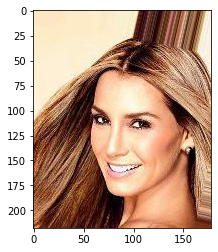

In [32]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [33]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [34]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='../../data/celeba/celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='../../data/celeba/celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='../../data/celeba/celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [35]:
df = pd.read_csv('../../data/attr_celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])
df.loc[df['Male'] == -1, 'Male'] = 0

male_s = df[(df.Male==1) & (df.Smiling == 1)][:10]
male_ns = df[(df.Male==1) & (df.Smiling == -1)][:10]
female_s = df[(df.Male==0) & (df.Smiling == 1)][:10]
female_ns = df[(df.Male==0) & (df.Smiling == -1)][:10]

male_s.to_csv('male_s.csv')
male_ns.to_csv('male_ns.csv')
female_s.to_csv('female_s.csv')
female_ns.to_csv('female_ns.csv')

train_male_s_dataset = CelebaDataset(csv_path='male_s.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

train_male_ns_dataset = CelebaDataset(csv_path='male_ns.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

train_female_s_dataset = CelebaDataset(csv_path='female_s.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

train_female_ns_dataset = CelebaDataset(csv_path='female_ns.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)


train_male_s_loader = DataLoader(dataset=train_male_s_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

train_male_ns_loader = DataLoader(dataset=train_male_ns_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

train_female_s_loader = DataLoader(dataset=train_female_s_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

train_female_ns_loader = DataLoader(dataset=train_female_ns_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

target_fns_batch = next(iter(train_female_ns_loader))
target_fns_images, _ = target_fns_batch

target_fs_batch = next(iter(train_female_s_loader))
target_fs_images, _ = target_fs_batch

target_mns_batch = next(iter(train_male_ns_loader))
target_mns_images, _ = target_mns_batch

target_ms_batch = next(iter(train_male_s_loader))
target_ms_images, _ = target_ms_batch

In [36]:
##########################
### MODEL
##########################
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 256*torch.cuda.device_count()
#DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [37]:
target_model = resnet18(2)
#MS_FS
target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MS30K_FS_30K)_3e_pth", map_location ='cpu'))
#MNS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MNS_30K_FNS_30K)_pth", map_location ='cpu'))
#MNS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MNS_30K_FS_30K)_pth", map_location ='cpu'))
#MS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MS_30K_FNS_30K)_pth", map_location ='cpu'))
#MS_30_MNS_10_FS_30_FNS_10
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_MNS_10K_FS_30K_FNS_10K)_pth", map_location ='cpu'))
#MS_10_MNS_30_FS_10_FNS_30
#target_model.load_state_dict(torch.load("../../out/models/PIA_HK/TM(MS_30K_FNS_30K)_3E_HK.pth", map_location ='cpu'))
target_model.eval()
print("Model Loaded")

Model Loaded


<h1>SHAP Explain</h1>

tensor(0)


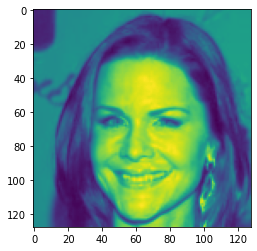

In [38]:
target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)
target_image = target_images[2]
plt.imshow(target_image.numpy()[0])
print(target_labels[0])

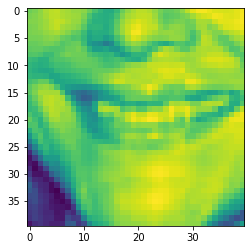

In [39]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
r_img = target_image
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())
plt.imshow(target_image[0:3, 80:120, 40:80].numpy()[0])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 461.20555777359823
shap_sum 309.1962419326683


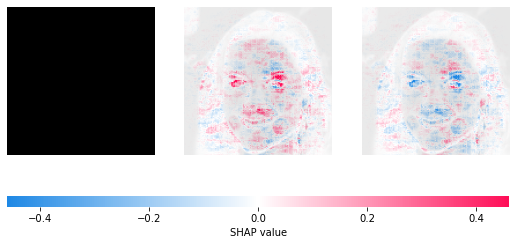

In [40]:
target_shap_values = shap_plot(target_explain, r_img, 49152)
target_female = torch.tensor(target_shap_values[0]).view(-1) 
target_male = torch.tensor(target_shap_values[1]).view(-1)

###
target_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>PIA</h1>

In [41]:
target_female_smile_crop = target_female_crop

In [42]:
res = sum(target_female_smile_crop - target_female_crop)
res

tensor(0., dtype=torch.float64)

In [43]:
target_male_smile_crop = target_male_crop

In [44]:
res = sum(target_male_smile_crop - target_male_crop)
res

tensor(0., dtype=torch.float64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 592.4126798571476
shap_sum 480.2107610749672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 798.1613430112778
shap_sum 543.8589949744843
tensor(13.7823, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 558.1781287310093
shap_sum 398.83985606982696
tensor(37.1046, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 512.0046751762513
shap_sum 422.06353924776914
tensor(44.1703, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 610.550849599309
shap_sum 519.8121370784434
tensor(10.2896, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 657.5607477114077
shap_sum 443.147572832243
tensor(35.3934, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 567.7245999928177
shap_sum 374.95222553047324
tensor(8.7594, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 554.5127929215105
shap_sum 475.196856127199
tensor(11.9316, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 678.5662594439623
shap_sum 558.4091317039242
tensor(16.2019, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 816.237825931993
shap_sum 767.3919638964312
tensor(49.9306, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 537.4310629196988
shap_sum 438.65525906090306
tensor(16.2910, dtype=torch.float64)


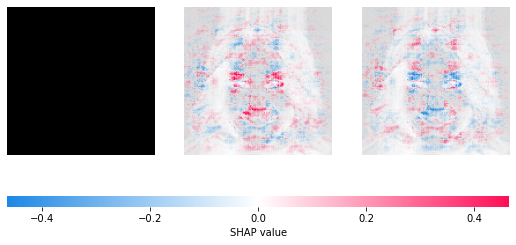

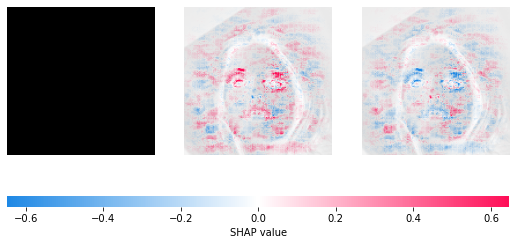

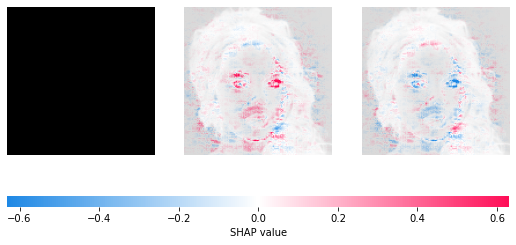

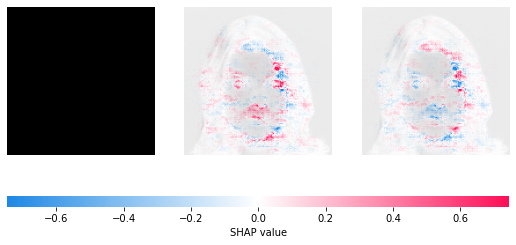

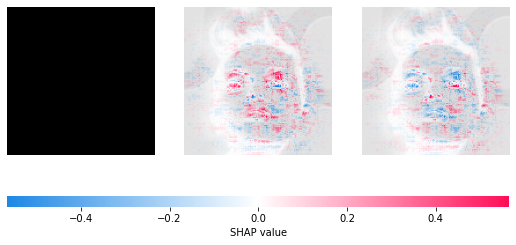

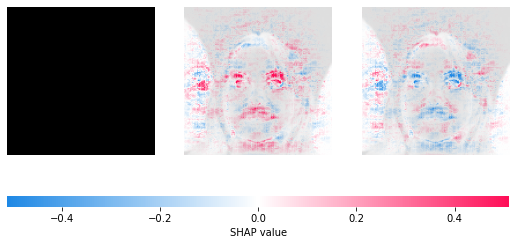

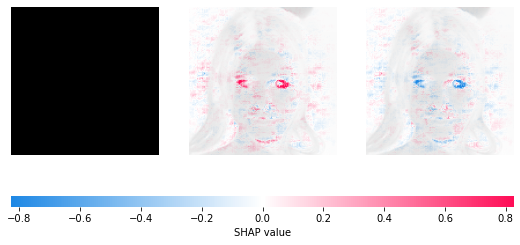

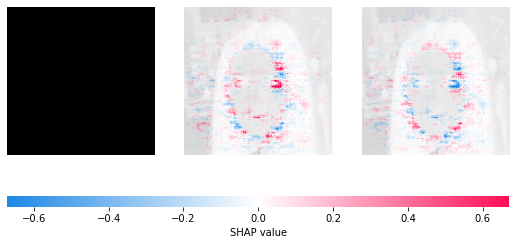

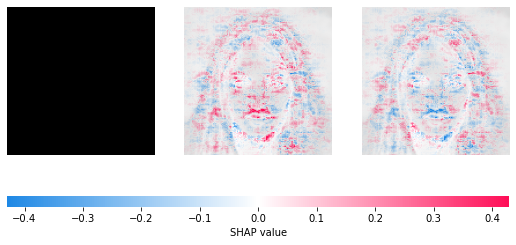

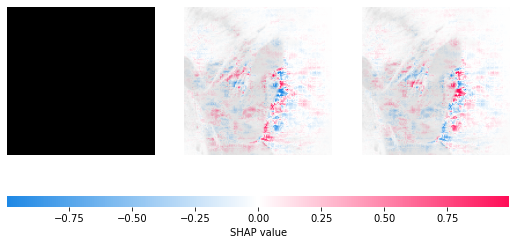

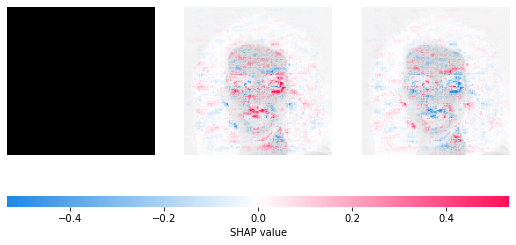

In [45]:
target_explain = shap.DeepExplainer(target_model, target_baseline)

for smile_female_img in range(2,10):
    
    target_image = target_fs_images[smile_female_img]
    r_img = target_image
    target_shap_values = shap_plot(target_explain, r_img, 49152)
    target_female = torch.tensor(target_shap_values[0]).view(-1) 
    #target_male = torch.tensor(target_shap_values[1]).view(-1)
    
    target_smile_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
    #target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
    
    for non_smile_female_img in range(10):
        target_image = target_fns_images[non_smile_female_img]
        r_img = target_image
        target_shap_values = shap_plot(target_explain, r_img, 49152)
        target_female = torch.tensor(target_shap_values[0]).view(-1) 
        #target_male = torch.tensor(target_shap_values[1]).view(-1)

        target_non_smile_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
        #target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
        
        res = sum(target_non_smile_female_crop - target_smile_female_crop)
        print(res)
    
    break

In [ ]:
target_explain = shap.DeepExplainer(target_model, target_baseline)

for smile_male_img in range(2,10):
    
    target_image = target_ms_images[smile_male_img]
    r_img = target_image
    target_shap_values = shap_plot(target_explain, r_img, 49152)
    #target_male = torch.tensor(target_shap_values[0]).view(-1) 
    target_male = torch.tensor(target_shap_values[1]).view(-1)
    
    #target_smile_male_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
    target_smile_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
    
    for non_smile_male_img in range(10):
        target_image = target_mns_images[non_smile_male_img]
        r_img = target_image
        target_shap_values = shap_plot(target_explain, r_img, 49152)
        #target_male = torch.tensor(target_shap_values[0]).view(-1) 
        target_male = torch.tensor(target_shap_values[1]).view(-1)

        #target_non_smile_male_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
        target_non_smile_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
        
        res = sum(target_non_smile_male_crop - target_smile_male_crop)
        print(res)
    
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 436.7786786051031
shap_sum 603.5118984934179
